## Gradient-Based Optimiztion for IK problem:
This question is asking to solve inverse kinematics with a gradient-based optmizitation method.

For question 1, 2, and 3, please look at the code. I ran this notebook in Drake and captured a video too. If you have Drake up and running, you can try it there.

In [1]:
import numpy as np
import time
from IPython.display import clear_output, SVG, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    Cylinder,
    DiagramBuilder,
    InverseKinematics,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    RigidTransform,
    Role,
    RollPitchYaw,
    RotationMatrix,
    Solve,
    StartMeshcat,
    JacobianWrtVariable,
    Parser,
    RevoluteJoint,
    JointSliders
)

from manipulation.meshcat_utils import (  # TODO(russt): switch to pydrake version
    _MeshcatPoseSliders,
)
from manipulation.scenarios import AddIiwa, AddShape, AddWsg
from manipulation.utils import ConfigureParser, running_as_notebook
from scipy.spatial.transform import Rotation as R


In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


# First Approach. 
Min distance in C-space. 
We can define the cost function as the quadratic of the error in joint space. Subject to satisfying 
Jacobian relationship. 

$min \space {1\over2}\Delta\theta^T\Delta\theta$    
$s.t. \space \space \Delta x = J(\theta) \Delta \theta$

With largran multiplier we can solve the problem which is:      
$\Delta \theta = \alpha J^\# \Delta x$

We need the pseudo inverse of the jacobian to use in the iteration for updating the joint values. So the gradient descent basically looks like:      
$\theta_{k+1} = \theta_{k} + \alpha J^{\#} \Delta x$        

using the pseduo inverse $J^{\#}$ make the optmization process to look for the shortes path in C-space. As a result, this is a method converges fast relative to the other one but matrix inversion is necessary here.

The Kuka arm here is redundant manipulator and psedue inverse of the Jacobian
would be a better approach to find the closest q values in the next step. There are infinte solution basically but psedudo inverse will give us the one that is the min in least square form.

In [4]:
def calcLambda(J, deltaX):
    return (np.linalg.inv(J @ J.T) @ deltaX).reshape(6,1)

def calcCost(q_current, q_next):
    return 1/2*np.linalg.norm(q_current - q_next)

def calcCost2(q_current, q_next, J, deltaX):
    deltaQ = q_current - q_next
    return calcCost(q_current, q_next) + calcLambda(J, deltaX).T @(deltaX.reshape(6,1) - J @ deltaQ)

def calcCostGradient(q_current, q_next, J, deltaX):
    deltaQ = q_current - q_next
    lmbd = calcLambda(J, deltaX)
    return deltaQ - (lmbd.T @ J).reshape(7,1)

def calcDeltaX(p_current, quat_current, p_target, quat_target) -> np.ndarray:
    '''
    Calculates error in Cartesian space

    Arguments:
        x: current pose.
        y: target pose

    Returns:
        difference in pose
    '''

    # position current to target
    position_error = p_target - p_current
    
    # Rc, Rtarget,. Rc * Rct = Rt => Rct = Rt * Rc^-1
    # quaternion current to target
    r_current_inv = R.from_quat(quat_current).inv()
    rct = R.from_quat(quat_target) * r_current_inv
    r_error = rct.as_rotvec() # angle * axis

    out = np.zeros(6)
    out[:3] = r_error
    out[3:] = position_error
    return out

In [ ]:
def teleop_inverse_kinematics():
    # params
    alpha = 0.2
    max_iteration = 100
    min_deltaX = 1e-3

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    iiwa = AddIiwa(plant_1_1_1)
    wsg = AddWsg(plant, iiwa, welded=True)
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(delete_prefix_initialization_event=False),
    )

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    q0 = plant.GetPositions(plant_context)
    gripper_frame = plant.GetFrameByName("body", wsg)
    base_frame = plant.GetBodyByName("iiwa_link_0").body_frame()
    # Frame.CalcPoseInWorld().translation()

    def my_callback(context, pose):
    
        # target pose
        p_target = pose.translation()
        quat_target = R.from_matrix(pose.rotation().matrix()).as_quat()

        # initial state
        q_current = q0
        it = 0

        costs = []
        cost2s = []
        grds = []
        errors = [] # Cartesian error
        while it < max_iteration:
            # forward kineamtics. get gripper frame
            transform = gripper_frame.CalcPoseInWorld(plant_context)
            quat_current = R.from_matrix(transform.rotation().matrix()).as_quat()
            p_current = transform.translation()

            # check error between current pose of the end-effector and the target pose
            deltaX = calcDeltaX(p_current, quat_current, p_target, quat_target)
            error = np.linalg.norm(deltaX)
            if error < min_deltaX:
                break


            # calc jacobain
            J = plant.CalcJacobianSpatialVelocity(
                context=plant_context, 
                with_respect_to=JacobianWrtVariable.kQDot,
                frame_B=gripper_frame, 
                p_BoBp_B=np.zeros(3),
                frame_A=plant.world_frame(),
                frame_E=plant.world_frame()
            )
            
            np.set_printoptions(precision=3, suppress=True)

            # calculate the next joint values by gradient descent equation
            q_current = q_current.reshape(7,1)
            q_next = q_current + alpha * np.linalg.pinv(J) @ deltaX.reshape(6,1)

            # update the robot in the scene
            plant.SetPositions(plant_context, q_next)

            print('iteration', it)
            print('q_current', q_current.T)
            print('q_next', q_next.T)
            cost = calcCost(q_current, q_next)
            costs.append(cost)
            lambd = calcLambda(J, deltaX)
            cost2 = calcCost2(q_current, q_next, J, deltaX)[0][0]
            cost2s.append(cost2)

            grd = calcCostGradient(q_current, q_next, J, deltaX)
            grds.append(grd)

            errors.append(error)

            q_current = q_next
            it += 1

        plt.figure()
        plt.plot(range(it), costs, label=["quadratic cost value"])
        plt.xlabel("iteration")
        plt.ylabel("cost")
        plt.legend()
        display(plt.show())

        grds = np.array(grds)
        plt.figure()
        plt.plot(range(it), errors, label=["Cartesian Error"])
        plt.xlabel("iteration")
        plt.ylabel("deltaX")
        plt.legend()
        display(plt.show())

        if it == max_iteration:
            print('did not converge in {} iterations. Cost is at: {}'.format(max_iteration, cost))
        else:
            print('converged at iteration {}. Catesian error: {} cost: {}'.format(it, error, cost))
            print('solution:\n{}'.format(q_current.T))
        clear_output(wait=True)

    meshcat.DeleteAddedControls()
    sliders = _MeshcatPoseSliders(meshcat)
    sliders.SetPose(
        plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body", wsg))
    )
    sliders.Run(visualizer, context, my_callback)


teleop_inverse_kinematics()

# Second approach:
Min distance in Cartesian space for objective function.     

Forward kinematics:         
$x = F(\theta)$             
$\Delta x = x_{target} - F(\theta)$             


Optimization problem:               
$min \space {1\over2}\Delta x^T\Delta x$    

No inverse matrix needed, its a simpler computatoin but needs many iterations to converge. The reason is that it does not aim at find the shortest path in C-space neccesarily. Cost function does not inforce that.        

The gradient descent basically looks like:              
$\theta_{k+1} = \theta_{k} + \alpha J^T \Delta x$        



In [3]:
def calcCost(deltaX):
    return 1/2*np.linalg.norm(deltaX)


def calcDeltaX(p_current, quat_current, p_target, quat_target) -> np.ndarray:
    '''
    Calculates error in Cartesian space

    Arguments:
        x: current pose.
        y: target pose

    Returns:
        difference in pose
    '''

    # position current to target
    position_error = p_target - p_current
    
    # Rc, Rtarget,. Rc * Rct = Rt => Rct = Rt * Rc^-1
    # quaternion current to target
    r_current_inv = R.from_quat(quat_current).inv()
    rct = R.from_quat(quat_target) * r_current_inv
    r_error = rct.as_rotvec() # angle * axis

    out = np.zeros(6)
    out[:3] = r_error
    out[3:] = position_error
    return out

In [ ]:
def teleop_inverse_kinematics():
    # params
    alpha = 0.2
    max_iteration = 200
    min_deltaX = 1e-3

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa, welded=True)
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(delete_prefix_initialization_event=False),
    )

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    q0 = plant.GetPositions(plant_context)
    gripper_frame = plant.GetFrameByName("body", wsg)
    base_frame = plant.GetBodyByName("iiwa_link_0").body_frame()
    # Frame.CalcPoseInWorld().translation()

    def my_callback(context, pose):
    
        # target pose
        p_target = pose.translation()
        quat_target = R.from_matrix(pose.rotation().matrix()).as_quat()

        # initial state
        q_current = q0
        it = 0

        costs = [] # Cartesian Error
        while it < max_iteration:
            # forward kineamtics. get gripper frame
            transform = gripper_frame.CalcPoseInWorld(plant_context)
            quat_current = R.from_matrix(transform.rotation().matrix()).as_quat()
            p_current = transform.translation()

            # check error between current pose of the end-effector and the target pose
            deltaX = calcDeltaX(p_current, quat_current, p_target, quat_target)
            cost = calcCost(deltaX)

            if cost < min_deltaX:
                break


            # calc jacobain
            J = plant.CalcJacobianSpatialVelocity(
                context=plant_context, 
                with_respect_to=JacobianWrtVariable.kQDot,
                frame_B=gripper_frame, 
                p_BoBp_B=np.zeros(3),
                frame_A=plant.world_frame(),
                frame_E=plant.world_frame()
            )
             
            # calculate the next joint values by gradient descent equation
            q_current = q_current.reshape(7,1)
            q_next = q_current + alpha * J.T @ deltaX.reshape(6,1)

            # update the robot in the scene
            plant.SetPositions(plant_context, q_next)

            costs.append(cost)

            q_current = q_next
            it += 1

        plt.figure()
        plt.plot(range(it), costs, label=["quadratic cost value"])
        plt.xlabel("iteration")
        plt.ylabel("cost")
        plt.legend()
        display(plt.show())

        if it == max_iteration:
            print('did not converge in {} iterations. Cost is at: {}'.format(max_iteration, cost))
        else:
            print('converged at iteration {}. Cost: {}'.format(it, cost))
            print('solution:\n{}'.format(q_current.T))
        clear_output(wait=True)

    meshcat.DeleteAddedControls()
    sliders = _MeshcatPoseSliders(meshcat)
    sliders.SetPose(
        plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body", wsg))
    )
    sliders.Run(visualizer, context, my_callback)


teleop_inverse_kinematics()

# Dual manipulators:
Min distance in Cartesian space between the two end-effector for objective function. The crucial point here is that do not consider the orientation in the distance. We can not make the two robot come to gether at the same orienation, or their bases have to be very close.     

Forward kinematics:         
$x = F(\theta)$             
$\Delta x = x_{target} - F(\theta)$             


Optimization problem:               
$min \space {1\over2}\Delta x^T\Delta x$    

No inverse matrix needed, its a simpler computatoin but needs many iterations to converge. The reason is that it does not aim at find the shortest path in C-space neccesarily. Cost function does not inforce that.        

The gradient descent basically looks like:              
$\theta_{k+1} = \theta_{k} + \alpha J^T \Delta x$        



In [3]:
def calcCost(deltaX):
    return 1/2*np.linalg.norm(deltaX)

def calcDeltaX(p_current, quat_current, p_target, quat_target) -> np.ndarray:
    '''
    Calculates error in Cartesian space

    Arguments:
        x: current pose.
        y: target pose

    Returns:
        difference in pose
    '''

    # position current to target
    position_error = p_target - p_current
    
    # Rc, Rtarget,. Rc * Rct = Rt => Rct = Rt * Rc^-1
    # quaternion current to target
    r_current_inv = R.from_quat(quat_current).inv()
    rct = R.from_quat(quat_target) * r_current_inv
    r_error = rct.as_rotvec() # angle * axis

    out = np.zeros(6)
    out[:3] = r_error
    out[3:] = position_error
    return out

def AddIiwaAt(plant, q0, base_location=[0,0,0], model_instance_name="iiwa_7"):
    parser = Parser(plant)
    iiwa = parser.AddModelsFromUrl(
        f"package://drake_models/iiwa_description/sdf/iiwa7_no_collision.sdf"
    )[0]
    plant.RenameModelInstance(iiwa, model_instance_name)

    plant.WeldFrames(plant.world_frame(), 
                    plant.GetFrameByName("iiwa_link_0", iiwa), 
                    RigidTransform(base_location)
                )

    # Set default positions:
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1

    return iiwa

def AddWsgWithName(plant, iiwa_model_instance, 
                roll=np.pi / 2.0, welded=False, sphere=False, name='gripper'):
    parser = Parser(plant)
    ConfigureParser(parser)
    if welded:
        if sphere:
            file = "package://manipulation/schunk_wsg_50_welded_fingers_sphere.sdf"
        else:
            file = "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    else:
        file = (
            "package://drake_models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf"
        )

    directives = f"""
directives:
- add_model:
    name: gripper
    file: {file}
"""
    gripper = parser.AddModelsFromString(directives, ".dmd.yaml")[0]
    plant.RenameModelInstance(gripper, name)


    X_7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, roll), [0, 0, 0.09])
    plant.WeldFrames(
        plant.GetFrameByName("iiwa_link_7", iiwa_model_instance),
        plant.GetFrameByName("body", gripper),
        X_7G,
    )
    return gripper

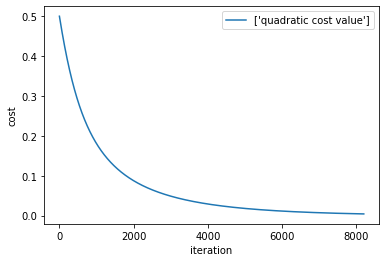

None

did not converge in 8200 iterations. Cost is at: 0.004291873908929368


In [38]:
def teleop_inverse_kinematics():
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    # params
    alpha = 0.001
    max_iteration = 8200
    min_deltaX = 1e-3

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

    q0_1 = [0, 0.1, 0, -1.2, 0, 1.0, 0]    
    iiwa_1 = AddIiwaAt(plant, q0_1, [0.0, 0.5, 0.0], "kuka1")
    wsg_1 = AddWsgWithName(plant, iiwa_1, welded=True, name="gripper1")

    q0_2 = [0, 0.1, 0, -1.2, 0, 1.0, 0]    
    iiwa_2 = AddIiwaAt(plant, q0_2, [0.0, -0.5, 0.0], "kuka2")
    wsg_2 = AddWsgWithName(plant, iiwa_2, welded=True, name="gripper2")

    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(delete_prefix_initialization_event=False),
    )
    # sliders = builder.AddSystem(JointSliders(meshcat, plant))

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    
    q0_1 = plant.GetPositions(plant_context, iiwa_1)
    gripper_frame_1 = plant.GetFrameByName("body", wsg_1)
    base_frame_1 = plant.GetBodyByName("iiwa_link_0", iiwa_1).body_frame()

    q0_2 = plant.GetPositions(plant_context, iiwa_2)
    gripper_frame_2 = plant.GetFrameByName("body", wsg_2)
    base_frame_2 = plant.GetBodyByName("iiwa_link_0", iiwa_2).body_frame()

    # to show the robots at their inital configurations    
    diagram.ForcedPublish(context)
    time.sleep(3)

    # initial state
    q_current = np.zeros(14)
    q_current[:7] = q0_1
    q_current[7:] = q0_2
    q_current.reshape(14,1)

    it = 0

    costs = [] # Cartesian Error
    while it < max_iteration:
        # forward kineamtics. get gripper frame
        transform_1 = gripper_frame_1.CalcPoseInWorld(plant_context)
        quat_current_1 = R.from_matrix(transform_1.rotation().matrix()).as_quat()
        p_current_1 = transform_1.translation()

        transform_2 = gripper_frame_2.CalcPoseInWorld(plant_context)
        quat_current_2 = R.from_matrix(transform_2.rotation().matrix()).as_quat()
        p_current_2 = transform_2.translation()

        # check error between current pose of the end-effector and the target pose
        deltaX = calcDeltaX(p_current_1, quat_current_1, p_current_2, quat_current_2)
        deltaX = deltaX[3:] # we must care only about the position
        cost = calcCost(deltaX)

        if cost < min_deltaX:
            break

        # calc jacobain
        J1 = plant.CalcJacobianSpatialVelocity(
            context=plant_context, 
            with_respect_to=JacobianWrtVariable.kQDot,
            frame_B=gripper_frame_1, 
            p_BoBp_B=np.zeros(3),
            frame_A=plant.world_frame(),
            frame_E=plant.world_frame()
        )
        # print(J1.shape)
        np.set_printoptions(precision=3, suppress=True)
        # print(J1)
        J2 = plant.CalcJacobianSpatialVelocity(
            context=plant_context, 
            with_respect_to=JacobianWrtVariable.kQDot,
            frame_B=gripper_frame_2, 
            p_BoBp_B=np.zeros(3),
            frame_A=plant.world_frame(),
            frame_E=plant.world_frame()
        )
        # print(J2)
            
        # calculate the next joint values by gradient descent equation
        J = J1 - J2
        J = J[3:,:]
        q_next = q_current.reshape(14,1) + alpha * J.T  @ deltaX.reshape(3,1) # J.T, np.linalg.pinv(J)

        # update the robot in the scene
        plant.SetPositions(plant_context, q_next)
        diagram.ForcedPublish(context)

        costs.append(cost)

        q_current = q_next
        it += 1
        
    
    plt.figure()
    plt.plot(range(it), costs, label=["quadratic cost value"])
    plt.xlabel("iteration")
    plt.ylabel("cost")
    plt.legend()
    display(plt.show())

    if it == max_iteration:
        print('did not converge in {} iterations. Cost is at: {}'.format(max_iteration, cost))
    else:
        print('converged at iteration {}. Cost: {}'.format(it, cost))
        print('solution:\n{}'.format(q_current.T))
    clear_output(wait=True)

    diagram.ForcedPublish(context)

teleop_inverse_kinematics()